In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [ ]:
class NoisyCIFAR10(Dataset):
    def __init__(self, dataset, noise_type='symmetric', eta=0.0, num_classes=10, transform=None):
        self.dataset = dataset
        self.noise_type = noise_type
        self.eta = eta
        self.num_classes = num_classes
        self.transform = transform
        self.labels = np.array(self.dataset.targets)

        if noise_type == 'symmetric':
            self.noisy_labels = self._add_symmetric_noise()
        elif noise_type == 'asymmetric':
            self.noisy_labels = self._add_asymmetric_noise()
        else:
            self.noisy_labels = self.labels.copy()

    def _add_symmetric_noise(self):
        noisy_labels = self.labels.copy()
        mask = np.random.rand(len(noisy_labels)) < self.eta
        indices = np.where(mask)[0]
        for i in indices:
            original = noisy_labels[i]
            candidates = list(range(self.num_classes))
            candidates.remove(original)
            noisy_labels[i] = np.random.choice(candidates)
        return noisy_labels

    def _add_asymmetric_noise(self):
        # Asymmetric mapping for CIFAR-10
        asymmetric_mapping = {
            0: 0, 1: 1, 2: 0, 3: 5, 4: 7, 5: 3, 6: 6, 7: 7, 8: 8, 9: 1
        }
        noisy_labels = self.labels.copy()
        mask = np.random.rand(len(noisy_labels)) < self.eta
        indices = np.where(mask)[0]
        for i in indices:
            original = noisy_labels[i]
            if original in asymmetric_mapping:
                noisy_labels[i] = asymmetric_mapping[original]
        return noisy_labels

    def __getitem__(self, index):
        img, _ = self.dataset[index]
        label = self.noisy_labels[index]
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.dataset)

In [ ]:
class NormalizedCrossEntropy(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, logits, labels):
        log_softmax = torch.nn.functional.log_softmax(logits, dim=1)
        numerator = -log_softmax[range(len(labels)), labels]
        denominator = -log_softmax.sum(dim=1)
        loss = numerator / denominator
        return loss.mean()

In [ ]:
class MAE(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, logits, labels):
        probs = torch.nn.functional.softmax(logits, dim=1)
        mae = 2 * (1 - probs[range(len(labels)), labels])
        return mae.mean()

In [ ]:
class RCE(nn.Module):
    def __init__(self, A=1e-4):
        super().__init__()
        self.A = A

    def forward(self, logits, labels):
        probs = torch.nn.functional.softmax(logits, dim=1)
        batch_size = logits.size(0)
        q = torch.full_like(probs, self.A)
        q[range(batch_size), labels] = 1.0
        rce = - (probs * torch.log(q)).sum(dim=1)
        return rce.mean()

In [ ]:
class APL(nn.Module):
    def __init__(self, active, passive, alpha=1.0, beta=1.0):
        super().__init__()
        self.active = active
        self.passive = passive
        self.alpha = alpha
        self.beta = beta

    def forward(self, logits, labels):
        active_loss = self.active(logits, labels)
        passive_loss = self.passive(logits, labels)
        return self.alpha * active_loss + self.beta * passive_loss

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128*4*4, 512), nn.ReLU(), nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
def train(loss_fn, noise_type='symmetric', eta=0.2, epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

    noisy_trainset = NoisyCIFAR10(trainset, noise_type=noise_type, eta=eta, transform=transform)
    trainloader = DataLoader(noisy_trainset, batch_size=128, shuffle=True)
    testloader = DataLoader(testset, batch_size=128, shuffle=False)

    #######
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)  # <-- ADD TRANSFORM
    testloader = DataLoader(testset, batch_size=128, shuffle=False)
    #######


    # Model setup
    model = SimpleCNN().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = loss_fn

    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        acc = 100 * correct / total
        best_acc = max(best_acc, acc)
        print(f'Epoch {epoch+1}: Test Acc = {acc:.2f}%')

    return best_acc

In [ ]:
losses = {
    'CE': nn.CrossEntropyLoss(),
    'NCE': NormalizedCrossEntropy(),
    'MAE': MAE(),
    'APL (NCE+MAE)': APL(NormalizedCrossEntropy(), MAE())
}

noise_rates = [0.2, 0.4, 0.6, 0.8]
results = {loss: [] for loss in losses}

for loss_name in losses:
    for eta in noise_rates:
        acc = train(losses[loss_name], eta=eta, epochs=10)
        results[loss_name].append(acc)

100%|██████████| 170M/170M [00:03<00:00, 43.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Test Acc = 49.88%
Epoch 2: Test Acc = 55.95%
Epoch 3: Test Acc = 62.83%
Epoch 4: Test Acc = 64.76%
Epoch 5: Test Acc = 67.08%
Epoch 6: Test Acc = 68.10%
Epoch 7: Test Acc = 70.51%
Epoch 8: Test Acc = 70.50%
Epoch 9: Test Acc = 68.64%
Epoch 10: Test Acc = 67.88%
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Test Acc = 43.34%
Epoch 2: Test Acc = 51.14%
Epoch 3: Test Acc = 57.33%
Epoch 4: Test Acc = 59.27%
Epoch 5: Test Acc = 60.65%
Epoch 6: Test Acc = 64.05%
Epoch 7: Test Acc = 62.00%
Epoch 8: Test Acc = 65.19%
Epoch 9: Test Acc = 63.35%
Epoch 10: Test Acc = 62.45%
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Test Acc = 33.56%
Epoch 2: Test Acc = 44.90%
Epoch 3: Test Acc = 44.81%
Epoch 4: Test Acc = 51

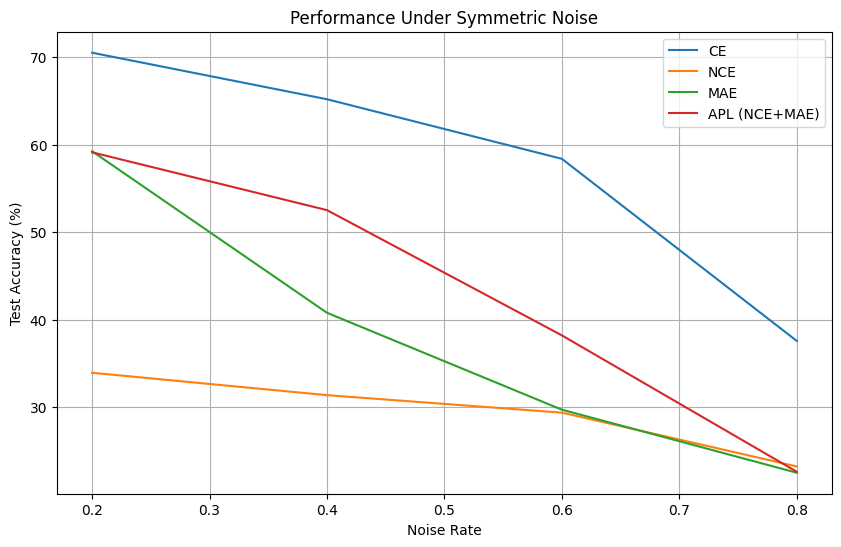

In [ ]:
plt.figure(figsize=(10, 6))
for loss_name in losses:
    plt.plot(noise_rates, results[loss_name], label=loss_name)
plt.xlabel('Noise Rate')
plt.ylabel('Test Accuracy (%)')
plt.title('Performance Under Symmetric Noise')
plt.legend()
plt.grid()
plt.show()